<a href="https://colab.research.google.com/github/williambiondi/RecommenderGS/blob/main/recommenderGranSasso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importazione dei dati e librerie


#Caricamento dati

In [1]:
!pip install tensorflow -q
!pip install transformers -q
!pip install tensorflow-recommenders -q
!pip install keras-tuner -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 5.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_recommenders as tfrs
from transformers import DistilBertTokenizer, TFDistilBertModel
from IPython import display
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import re
from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch
from ast import literal_eval
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow.keras.layers import Input, Concatenate, Embedding, Dense, Dropout, ReLU, Flatten, BatchNormalization
from tensorflow.keras.models import Model

In [3]:
items = pd.read_csv('https://raw.githubusercontent.com/williambiondi/RecommenderGS/main/ArticoliGransasso.csv')
customers = pd.read_csv('https://raw.githubusercontent.com/williambiondi/RecommenderGS/main/ClientiGransasso.csv')
purchases = pd.read_csv('https://raw.githubusercontent.com/williambiondi/RecommenderGS/main/OrdiniGransasso.csv')

In [4]:
items.drop(columns=['Unnamed: 0'], inplace=True)
customers.drop(columns=['Unnamed: 0'], inplace=True)
purchases.drop(columns=['Unnamed: 0'], inplace=True)

#Preparazione dati per modello


Annoto come interazione positiva (1) tutti gli articoli acquistati, come interazione negativa (0) tutti gli articoli rimborsati

In [5]:
interactions = [1 if row['RefundedEUR'] == 0 else 0 for _,row in purchases.iterrows()]
purchases["Interaction"] = interactions

In [6]:
text_combined = []
for idx, row in items.iterrows():
  descriptive = row['ItemName'].lower()+" "+row['Description']
  text_combined.append(descriptive)
items['TextInfo'] = text_combined

In [7]:
len_desc = [len(row['TextInfo'].split(" ")) for _,row in items.iterrows()]
max(len_desc)

190

Utilizzo DistilBERT per ottenere gli embeddings di tutta l'informazione testuale degli articoli (nome articolo e descrizione) a parte anche gli embeddings delle categorie

In [8]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
enc_input = tokenizer(items['TextInfo'].tolist(),
                      padding=True,
                      truncation=True,
                      max_length=150,
                      return_tensors='tf')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [9]:
distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [10]:
with tf.device('/CPU:0'):
  outputs = distilbert_model(enc_input)
  embeddings = outputs.last_hidden_state

In [11]:
embeddings_np = embeddings.numpy()
summary_embeddings = embeddings_np[:,0,:]
df_embeddings = pd.DataFrame(summary_embeddings)
df_embeddings.columns = [f'embedding_{i}' for i in range(df_embeddings.shape[1])]

In [12]:
items['Category_combined'] = items['Category'].apply(lambda x: ' '.join(x))
enc_input = tokenizer(items['Category_combined'].tolist(),
                      padding=True,
                      truncation=True,
                      max_length=20,
                      return_tensors='tf')
with tf.device('/CPU:0'):
  outputs = distilbert_model(enc_input)
  category_embeddings = outputs.last_hidden_state
category_embeddings_np = category_embeddings.numpy()
summary_category_embeddings = category_embeddings_np[:,0,:]
df_category_embeddings = pd.DataFrame(summary_category_embeddings)
df_category_embeddings.columns = [f'category_embedding_{i}' for i in range(df_category_embeddings.shape[1])]

In [13]:
df_category_embeddings.head()

,category_embedding_0,category_embedding_1,category_embedding_2,category_embedding_3,category_embedding_4,category_embedding_5,category_embedding_6,category_embedding_7,category_embedding_8,category_embedding_9,...,category_embedding_758,category_embedding_759,category_embedding_760,category_embedding_761,category_embedding_762,category_embedding_763,category_embedding_764,category_embedding_765,category_embedding_766,category_embedding_767
0,-0.057772,0.183025,0.119610,-0.696748,-0.141949,-0.084501,0.430838,0.352050,-0.317388,-0.270157,...,0.216081,-0.222772,0.007465,0.088298,0.123053,-0.18269,-0.047629,-0.085874,0.207535,0.519722
1,-0.057772,0.183025,0.119610,-0.696748,-0.141949,-0.084501,0.430838,0.352050,-0.317388,-0.270157,...,0.216081,-0.222772,0.007465,0.088298,0.123053,-0.18269,-0.047629,-0.085874,0.207535,0.519722
2,-0.003991,0.195033,0.163861,-0.568865,-0.057092,-0.201099,0.350111,0.403217,-0.281274,-0.351612,...,0.333690,-0.109416,-0.184354,0.027544,0.051049,-0.29962,0.105925,0.049944,0.232690,0.512860
3,-0.057772,0.183025,0.119610,-0.696748,-0.141949,-0.084501,0.430838,0.352050,-0.317388,-0.270157,...,0.216081,-0.222772,0.007465,0.088298,0.123053,-0.18269,-0.047629,-0.085874,0.207535,0.519722
4,-0.057772,0.183025,0.119610,-0.696748,-0.141949,-0.084501,0.430838,0.352050,-0.317388,-0.270157,...,0.216081,-0.222772,0.007465,0.088298,0.123053,-0.18269,-0.047629,-0.085874,0.207535,0.519722


In [14]:
df_embeddings.head()

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_758,embedding_759,embedding_760,embedding_761,embedding_762,embedding_763,embedding_764,embedding_765,embedding_766,embedding_767
0,-0.152692,-0.702594,0.226576,-0.092627,0.150878,-0.052346,0.132293,0.289687,-0.130669,-0.294651,...,-0.045851,-0.592888,0.098133,-0.310700,0.045292,-0.331142,-0.110403,-0.167462,0.064619,-0.084191
1,-0.183465,-0.758047,0.025607,-0.106879,0.167659,-0.116864,0.084983,0.325271,0.031012,-0.256441,...,-0.039702,-0.501641,0.018874,-0.313824,0.023122,-0.488100,-0.089356,-0.199527,0.250173,-0.131353
2,-0.235759,-0.616278,0.186698,-0.050991,0.163522,-0.045681,0.081499,0.254824,-0.088808,-0.285371,...,0.009386,-0.555698,0.095906,-0.385060,-0.018019,-0.202692,-0.129432,-0.250053,0.047501,-0.117531
3,-0.080284,-0.587355,0.281824,-0.119877,0.063588,-0.044179,0.075656,0.288735,-0.159558,-0.265397,...,0.126247,-0.505958,0.169416,-0.327713,0.025113,-0.154299,-0.163061,-0.110773,0.150633,0.053784
4,-0.136119,-0.455886,0.220127,-0.032341,0.044970,-0.166100,0.079893,0.324760,-0.202329,-0.267275,...,-0.074009,-0.526029,0.137117,-0.344637,-0.017099,-0.273234,-0.202651,-0.110191,0.116088,0.078280


In [41]:
df_full.head()

,Sku,ItemName,Category,UnitPrice,ItemId,Collection,Availability,Color,Gender,Description,...,embedding_764,embedding_765,embedding_766,embedding_767,Id,UserId,CreatedOnUtc,RefundedEUR,UnitPriceTaxEUR,Interaction
0,A20205716614238589,MICRO RHOMBUS STITCH CREW NECK,['Maglieria'],130.0,0,Fall-Winter,0,589,Men,crew neck sweater in pure merino wool with mic...,...,-0.110403,-0.167462,0.064619,-0.084191,8812,0,2021-01-01 09:29:05.2513839,0.0,130.0,1
1,A20205716614238589,MICRO RHOMBUS STITCH CREW NECK,['Maglieria'],130.0,0,Fall-Winter,0,589,Men,crew neck sweater in pure merino wool with mic...,...,-0.110403,-0.167462,0.064619,-0.084191,8860,47,2021-01-03 23:11:34.9635880,0.0,130.0,1
2,A20205716614238589,MICRO RHOMBUS STITCH CREW NECK,['Maglieria'],130.0,0,Fall-Winter,0,589,Men,crew neck sweater in pure merino wool with mic...,...,-0.110403,-0.167462,0.064619,-0.084191,9311,413,2021-02-13 12:39:33.7391675,0.0,130.0,1
3,A20205716614238589,MICRO RHOMBUS STITCH CREW NECK,['Maglieria'],130.0,0,Fall-Winter,0,589,Men,crew neck sweater in pure merino wool with mic...,...,-0.110403,-0.167462,0.064619,-0.084191,9772,276,2021-04-10 11:33:22.9952881,0.0,130.0,1
4,A20201312414230005,WAVE PATTERN TURTLENECK,['Maglieria'],160.0,1,Fall-Winter,0,5,Men,turtleneck sweater in pure merino wool embelli...,...,-0.089356,-0.199527,0.250173,-0.131353,8813,1,2021-01-01 09:39:57.3829465,0.0,160.0,1


In [42]:
items['Composition'] = items['Composition'].astype(str)
gender_lookup = StringLookup()
collection_lookup = StringLookup()
composition_lookup = StringLookup()

gender_lookup.adapt(items['Gender'])
collection_lookup.adapt(items['Collection'])
composition_lookup.adapt(items['Composition'])

items['Gender_encoded'] = gender_lookup(items['Gender'])
items['Collection_encoded'] = collection_lookup(items['Collection'])
items['Composition_encoded'] = composition_lookup(items['Composition'])

In [43]:
df_embeddings['ItemId'] = items['ItemId']
df_category_embeddings['ItemId'] = items['ItemId']
full_items = items.merge(df_embeddings, on='ItemId')
full_items = full_items.merge(df_category_embeddings, on='ItemId')
df_full = full_items.merge(purchases, on='ItemId')

#Divisione train test

In [52]:
def custom_train_val_test_split(df, test_size=0.2, val_size=0.1):
  df_sorted = df.sort_values(by=['user_id', 'date'], ascending=True)
  users = df_sorted['user_id'].unique()
  train_users, test_users = train_test_split(users, test_size=test_size+val_size, random_state=999)
  val_users, test_users = train_test_split(test_users, test_size=test_size/(test_size+val_size), random_state=999)

  train_df = df_sorted[df_sorted['user_id'].isin(train_users)]
  val_df = df_sorted[df_sorted['user_id'].isin(val_users)]
  test_df = df_sorted[df_sorted['user_id'].isin(test_users)]

  return train_df, val_df, test_df

In [36]:
def create_feature_dict_from_df(df, exclude_features=None):
  feature_dict = {}
  all_features = ["item_id", "collection", "gender", "composition",
                  "item_embedding", "category_embedding", "user_id", "interaction"]
  if exclude_features is None:
    exclude_features = []
  for feature in all_features:
    if feature not in exclude_features:
      if feature in ['item_embedding', 'category_embedding', 'user_id', 'interaction']:
        feature_dict[feature] = np.stack(df[feature].values)
      else:
        feature_dict[feature] = df[feature].values
  return feature_dict

In [46]:
def tf_dataset_from_feature_dict(feature_dict, batch_size=32):
  labels = feature_dict.pop("interaction")
  dataset = tf.data.Dataset.from_tensor_slices((feature_dict, labels))
  dataset = dataset.batch(batch_size)
  return dataset.prefetch(tf.data.AUTOTUNE)

In [53]:
feature_dict = {
    "item_id": df_full["ItemId"].values,
    "collection": df_full["Collection_encoded"].values,
    "gender": df_full["Gender_encoded"].values,
    "date": df_full["CreatedOnUtc"].values,
    "composition": df_full["Composition_encoded"].values,
    "item_embedding" : df_full[[f'embedding_{i}' for i in range(df_embeddings.shape[1]-1)]].values,
    "category_embedding" : df_full[[f'category_embedding_{i}' for i in range(df_category_embeddings.shape[1]-1)]].values,
    "user_id": df_full['UserId'].values.reshape(-1,1),
    "interaction" : df_full['Interaction'].values.reshape(-1,1)
}
df_dict = pd.DataFrame({
    "item_id": feature_dict["item_id"],
    "collection": feature_dict["collection"],
    "gender": feature_dict["gender"],
    "composition": feature_dict["composition"],
    "date": feature_dict["date"],
    "user_id": feature_dict["user_id"].reshape(-1),
    "interaction": feature_dict["interaction"].reshape(-1)
})
df_dict['item_embedding'] = list(map(list, feature_dict['item_embedding']))
df_dict['category_embedding'] = list(map(list, feature_dict['category_embedding']))

train_df, val_df, test_df = custom_train_val_test_split(df_dict, test_size=0.2, val_size=0.1)

#Modello senza Item Description


In [17]:
candidates_tf = tf.data.Dataset.from_tensor_slices({
    "item_id": full_items['ItemId'].values.reshape(-1,1),
    "category_embedding" : full_items[[f'category_embedding_{i}' for i in range(df_category_embeddings.shape[1]-1)]].values,
    "collection": full_items["Collection_encoded"].values,
    "gender": full_items["Gender_encoded"].values,
    "composition": full_items["Composition_encoded"].values
})
candidates_ds = candidates_tf.batch(32)

In [55]:
exclude_columns = ['item_embedding']

train_feature_dict = create_feature_dict_from_df(train_df, exclude_features=exclude_columns)
val_feature_dict = create_feature_dict_from_df(val_df, exclude_features=exclude_columns)
test_feature_dict = create_feature_dict_from_df(test_df, exclude_features=exclude_columns)


In [56]:
train = tf_dataset_from_feature_dict(train_feature_dict, batch_size=32)
val = tf_dataset_from_feature_dict(val_feature_dict, batch_size=32)
test = tf_dataset_from_feature_dict(test_feature_dict, batch_size=32)

In [72]:
class NoDescRecommender(tfrs.Model):

  def __init__(self, user_model, item_model, candidates):
    super().__init__()
    self.user_model = user_model
    self.item_model = item_model
    self.retrieval_task = tfrs.tasks.Retrieval(metrics=tfrs.metrics.FactorizedTopK(
            candidates = candidates.map(self.item_model)))
    self.rank_task = tfrs.tasks.Ranking(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
            metrics=[tf.keras.metrics.BinaryAccuracy()])

  def compute_loss(self, data, training = False):
    features, labels = data
    user_emb = self.user_model({"user_id": features['user_id']
                                })
    item_emb = self.item_model({"category_embedding":features['category_embedding'],
                                "gender":features['gender'],
                                "collection":features['collection'],
                                "composition": features["composition"],
                                })
    retrieval_loss = self.retrieval_task(user_emb, item_emb)
    predictions = tf.reduce_sum(user_emb * item_emb, axis=1)
    ranking_loss = self.rank_task( labels = labels, predictions = predictions)
    return retrieval_loss + ranking_loss

In [65]:
unique_user_ids = df_full['UserId'].unique().astype(str)
unique_item_ids = df_full['ItemId'].unique().astype(str)
embedding_dim = df_category_embeddings.shape[1] - 1

In [66]:
category_embedding_input = Input(shape=(df_category_embeddings.shape[1]-1,), name='category_embedding')
gender_input = Input(shape=(1,), name='gender')
collection_input = Input(shape=(1,), name='collection')
composition_input = Input(shape=(1,), name='composition')

item_inputs =[category_embedding_input, gender_input, collection_input, composition_input]
concatenated = Concatenate()(item_inputs)

x = Dense(128, activation='relu')(concatenated)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

item_model = Model(inputs=item_inputs, outputs=x)

In [67]:
user_id_input = Input(shape=(1,), name="user_id", dtype=tf.int32)
user_embedding = Embedding(input_dim=len(unique_user_ids), output_dim=embedding_dim, name="user_embedding")(user_id_input)

combined_input = Concatenate()([user_embedding])

x = Dense(128, activation="relu")(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Flatten()(x)

user_model = Model(inputs=[user_id_input], outputs=x)

In [73]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=10,
                                              mode='min',
                                              start_from_epoch = 25,
                                              restore_best_weights=True)

In [74]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.999,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [75]:
recommender = NoDescRecommender(user_model, item_model, candidates_ds)
recommender.compile(optimizer = optimizer)
history = recommender.fit(train,
                validation_data = val,
                epochs=100, callbacks=[early_stop])

Epoch 1/100
435/435 [==============================] - 88s 195ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0151 - factorized_top_k/top_5_categorical_accuracy: 0.0167 - factorized_top_k/top_10_categorical_accuracy: 0.0183 - factorized_top_k/top_50_categorical_accuracy: 0.0273 - factorized_top_k/top_100_categorical_accuracy: 0.0360 - binary_accuracy: 0.8202 - loss: 113.3451 - regularization_loss: 0.0000e+00 - total_loss: 113.3451 - val_factorized_top_k/top_1_categorical_accuracy: 0.0021 - val_factorized_top_k/top_5_categorical_accuracy: 0.0037 - val_factorized_top_k/top_10_categorical_accuracy: 0.0079 - val_factorized_top_k/top_50_categorical_accuracy: 0.0195 - val_factorized_top_k/top_100_categorical_accuracy: 0.0289 - val_binary_accuracy: 0.7633 - val_loss: 38.0490 - val_regularization_loss: 0.0000e+00 - val_total_loss: 38.0490
Epoch 2/100
435/435 [==============================] - 90s 206ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0454 - factorized_top_k/top_5

KeyboardInterrupt: 

In [ ]:
metrics = history.history
# Plot loss
plt.plot(metrics['loss'], label='Training Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot categorical accuracy
plt.plot(metrics['factorized_top_k/top_1_categorical_accuracy'], label='Top_1 Training Accuracy')
plt.plot(metrics['val_factorized_top_k/top_1_categorical_accuracy'], label='Top_1 Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Categorical Accuracy')
plt.legend()
plt.show()

# Plot binary accuracy
plt.plot(metrics['binary_accuracy'], label='Training Accuracy')
plt.plot(metrics['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Binary Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Categorical Accuracy')
plt.legend()
plt.show()

In [ ]:
test_metrics = recommender.evaluate(test, return_dict=True)
print(test_metrics)
#recommender.save("no_desc_model.keras")

#Modello solo Item Description


In [76]:
exclude_columns = [ "collection", "gender", "composition", "category_embedding"]

train_feature_dict = create_feature_dict_from_df(train_df, exclude_features=exclude_columns)
val_feature_dict = create_feature_dict_from_df(val_df, exclude_features=exclude_columns)
test_feature_dict = create_feature_dict_from_df(test_df, exclude_features=exclude_columns)

In [77]:
train = tf_dataset_from_feature_dict(train_feature_dict, batch_size=32)
val = tf_dataset_from_feature_dict(val_feature_dict, batch_size=32)
test = tf_dataset_from_feature_dict(test_feature_dict, batch_size=32)

In [78]:
candidates_tf = tf.data.Dataset.from_tensor_slices({
    "item_id": full_items['ItemId'].values.reshape(-1,1),
    "item_embedding" : full_items[[f'embedding_{i}' for i in range(df_embeddings.shape[1]-1)]].values
})
candidates_ds = candidates_tf.batch(32)

In [79]:
class CFRecommender(tfrs.Model):

  def __init__(self, user_model, item_model, candidates):
    super().__init__()
    self.user_model = user_model
    self.item_model = item_model
    self.retrieval_task = tfrs.tasks.Retrieval(metrics=tfrs.metrics.FactorizedTopK(
            candidates = candidates.map(self.item_model)))
    self.rank_task = tfrs.tasks.Ranking(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
            metrics=[tf.keras.metrics.BinaryAccuracy()])

  def compute_loss(self, data, training = False):
    features, labels = data
    user_emb = self.user_model(features['user_id'])
    item_emb = self.item_model(features['item_embedding'])
    retrieval_loss = self.retrieval_task(user_emb, item_emb)
    predictions = tf.reduce_sum(user_emb * item_emb, axis=1)
    ranking_loss = self.rank_task( labels = labels, predictions = predictions)
    return retrieval_loss + ranking_loss

In [86]:
unique_user_ids = df_full['UserId'].unique().astype(str)
unique_item_ids = df_full['ItemId'].unique().astype(str)

In [87]:
unique_user_ids

array(['0', '47', '413', ..., '5223', '5229', '5230'], dtype='<U21')

In [88]:

embedding_dim = df_embeddings.shape[1] - 1
user_model = tf.keras.Sequential([
                                  tf.keras.layers.Embedding(input_dim = len(unique_user_ids), output_dim = embedding_dim, input_length=1),
                                  tf.keras.layers.Flatten(),
                                  tf.keras.layers.Dense(256),
                                  tf.keras.layers.ReLU(),
                                  tf.keras.layers.BatchNormalization(),
                                  tf.keras.layers.Dropout(0.2),
                                  tf.keras.layers.Dense(128),
                                  tf.keras.layers.ReLU(),
                                  tf.keras.layers.BatchNormalization(),
                                  tf.keras.layers.Dropout(0.2)
                                  ])

item_model = tf.keras.Sequential([tf.keras.Input(shape=(embedding_dim,), dtype=tf.float32, name='item_embedding'),
                                  tf.keras.layers.Dense(256),
                                  tf.keras.layers.ReLU(),
                                  tf.keras.layers.BatchNormalization(),
                                  tf.keras.layers.Dropout(0.2),
                                  tf.keras.layers.Dense(128),
                                  tf.keras.layers.ReLU(),
                                  tf.keras.layers.BatchNormalization(),
                                  tf.keras.layers.Dropout(0.2)
                                ])

In [89]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=10,
                                              mode='min',
                                              start_from_epoch = 25,
                                              restore_best_weights=True)

In [90]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.999,
    staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [91]:
recommender = CFRecommender(user_model, item_model, candidates_ds)
recommender.compile(optimizer = optimizer)
history = recommender.fit(train,
                validation_data = val,
                epochs=100, callbacks=[early_stop])

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['item_id'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


170/435 [==========>...................] - ETA: 49s - factorized_top_k/top_1_categorical_accuracy: 0.0355 - factorized_top_k/top_5_categorical_accuracy: 0.0449 - factorized_top_k/top_10_categorical_accuracy: 0.0509 - factorized_top_k/top_50_categorical_accuracy: 0.0730 - factorized_top_k/top_100_categorical_accuracy: 0.0989 - binary_accuracy: 0.7642 - loss: 112.0308 - regularization_loss: 0.0000e+00 - total_loss: 112.0308

KeyboardInterrupt: 

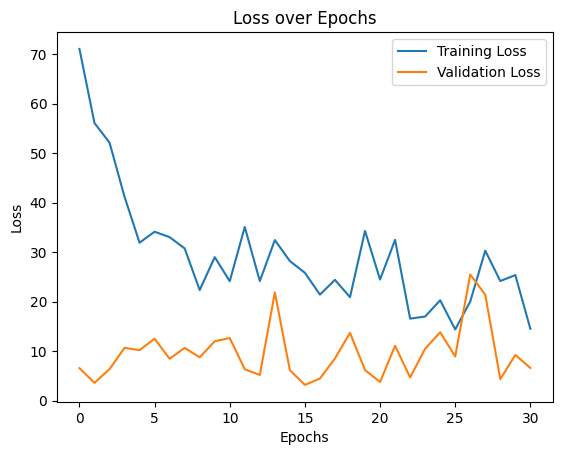

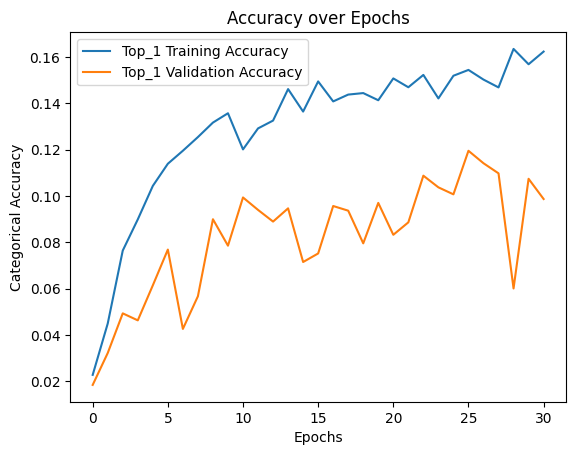

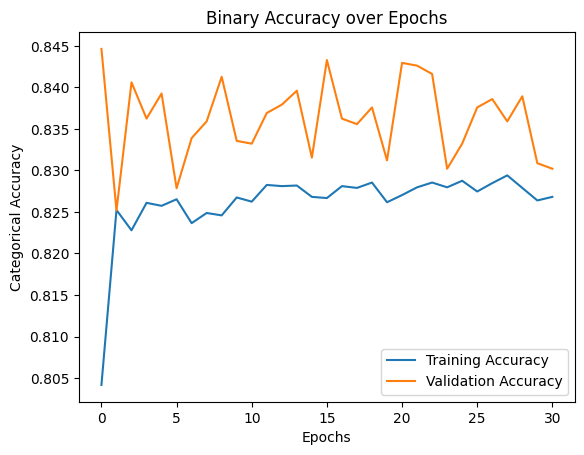

In [24]:
metrics = history.history
# Plot loss
plt.plot(metrics['loss'], label='Training Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot categorical accuracy
plt.plot(metrics['factorized_top_k/top_1_categorical_accuracy'], label='Top_1 Training Accuracy')
plt.plot(metrics['val_factorized_top_k/top_1_categorical_accuracy'], label='Top_1 Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Categorical Accuracy')
plt.legend()
plt.show()

# Plot binary accuracy
plt.plot(metrics['binary_accuracy'], label='Training Accuracy')
plt.plot(metrics['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Binary Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Categorical Accuracy')
plt.legend()
plt.show()

In [25]:
test_metrics = recommender.evaluate(test, return_dict=True)
print(test_metrics)
#recommender.save("desc_model.keras")

94/94 [==============================] - 17s 175ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0161 - factorized_top_k/top_5_categorical_accuracy: 0.0201 - factorized_top_k/top_10_categorical_accuracy: 0.0248 - factorized_top_k/top_50_categorical_accuracy: 0.0637 - factorized_top_k/top_100_categorical_accuracy: 0.0979 - binary_accuracy: 0.8182 - loss: 145.6574 - regularization_loss: 0.0000e+00 - total_loss: 145.6574
{'factorized_top_k/top_1_categorical_accuracy': 0.016096578910946846, 'factorized_top_k/top_5_categorical_accuracy': 0.02012072503566742, 'factorized_top_k/top_10_categorical_accuracy': 0.02481555938720703, 'factorized_top_k/top_50_categorical_accuracy': 0.0637156292796135, 'factorized_top_k/top_100_categorical_accuracy': 0.09792085736989975, 'binary_accuracy': 0.8182427883148193, 'loss': 23.475000381469727, 'regularization_loss': 0, 'total_loss': 23.475000381469727}


#Modello con Item description

In [92]:
candidates_tf = tf.data.Dataset.from_tensor_slices({
    "item_id": full_items['ItemId'].values.reshape(-1,1),
    "item_embedding" : full_items[[f'embedding_{i}' for i in range(df_embeddings.shape[1]-1)]].values,
    "category_embedding" : full_items[[f'category_embedding_{i}' for i in range(df_category_embeddings.shape[1]-1)]].values,
    "collection": full_items["Collection_encoded"].values,
    "gender": full_items["Gender_encoded"].values,
    "composition": full_items["Composition_encoded"].values
})
candidates_ds = candidates_tf.batch(32)

In [93]:
exclude_columns = None

train_feature_dict = create_feature_dict_from_df(train_df, exclude_features=exclude_columns)
val_feature_dict = create_feature_dict_from_df(val_df, exclude_features=exclude_columns)
test_feature_dict = create_feature_dict_from_df(test_df, exclude_features=exclude_columns)


In [94]:
train = tf_dataset_from_feature_dict(train_feature_dict, batch_size=32)
val = tf_dataset_from_feature_dict(val_feature_dict, batch_size=32)
test = tf_dataset_from_feature_dict(test_feature_dict, batch_size=32)

In [102]:
class CFRecommender(tfrs.Model):

  def __init__(self, user_model, item_model, candidates):
    super().__init__()
    self.user_model = user_model
    self.item_model = item_model
    self.retrieval_task = tfrs.tasks.Retrieval(metrics=tfrs.metrics.FactorizedTopK(
            candidates = candidates.map(self.item_model)))
    self.rank_task = tfrs.tasks.Ranking(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
            metrics=[tf.keras.metrics.BinaryAccuracy()])

  def compute_loss(self, data, training = False):
    features, labels = data
    user_emb = self.user_model({"user_id": features['user_id']
                                })
    item_emb = self.item_model({"item_embedding":features['item_embedding'],
                                "category_embedding":features['category_embedding'],
                                "gender":features['gender'],
                                "collection":features['collection'],
                                "composition": features["composition"],
                                })
    retrieval_loss = self.retrieval_task(user_emb, item_emb)
    predictions = tf.reduce_sum(user_emb * item_emb, axis=1)
    ranking_loss = self.rank_task( labels = labels, predictions = predictions)
    return retrieval_loss + ranking_loss

In [96]:
unique_user_ids = df_full['UserId'].unique().astype(str)
unique_item_ids = df_full['ItemId'].unique().astype(str)
embedding_dim = df_embeddings.shape[1] + df_category_embeddings.shape[1] - 2

In [97]:
item_embedding_input = Input(shape=(df_embeddings.shape[1]-1,), name='item_embedding')
category_embedding_input = Input(shape=(df_category_embeddings.shape[1]-1,), name='category_embedding')
gender_input = Input(shape=(1,), name='gender')
collection_input = Input(shape=(1,), name='collection')
composition_input = Input(shape=(1,), name='composition')

item_inputs =[item_embedding_input, category_embedding_input, gender_input, collection_input, composition_input]
concatenated = Concatenate()(item_inputs)

x = Dense(512, activation='relu')(concatenated)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)


item_model = Model(inputs=item_inputs, outputs=x)

In [98]:
user_id_input = Input(shape=(1,), name="user_id", dtype=tf.int32)
user_embedding = Embedding(input_dim=len(unique_user_ids), output_dim=embedding_dim, name="user_embedding")(user_id_input)

combined_input = Concatenate()([user_embedding])

x = Dense(512, activation="relu")(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Flatten()(x)

user_model = Model(inputs=[user_id_input], outputs=x)

In [99]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=10,
                                              mode='min',
                                              start_from_epoch = 25,
                                              restore_best_weights=True)

In [100]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.999,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [103]:
recommender = CFRecommender(user_model, item_model, candidates_ds)
recommender.compile(optimizer = optimizer)
history = recommender.fit(train,
                validation_data = val,
                epochs=100, callbacks=[early_stop])

Epoch 1/100
435/435 [==============================] - 152s 340ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0389 - factorized_top_k/top_5_categorical_accuracy: 0.0518 - factorized_top_k/top_10_categorical_accuracy: 0.0596 - factorized_top_k/top_50_categorical_accuracy: 0.0960 - factorized_top_k/top_100_categorical_accuracy: 0.1273 - binary_accuracy: 0.8253 - loss: 113.4553 - regularization_loss: 0.0000e+00 - total_loss: 113.4553 - val_factorized_top_k/top_1_categorical_accuracy: 0.0053 - val_factorized_top_k/top_5_categorical_accuracy: 0.0063 - val_factorized_top_k/top_10_categorical_accuracy: 0.0089 - val_factorized_top_k/top_50_categorical_accuracy: 0.0195 - val_factorized_top_k/top_100_categorical_accuracy: 0.0331 - val_binary_accuracy: 0.7622 - val_loss: 38.0232 - val_regularization_loss: 0.0000e+00 - val_total_loss: 38.0232
Epoch 2/100
221/435 [==============>...............] - ETA: 1:03 - factorized_top_k/top_1_categorical_accuracy: 0.0680 - factorized_top_k/top_5_cat

KeyboardInterrupt: 

In [ ]:
metrics = history.history
# Plot loss
plt.plot(metrics['loss'], label='Training Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot categorical accuracy
plt.plot(metrics['factorized_top_k/top_1_categorical_accuracy'], label='Top_1 Training Accuracy')
plt.plot(metrics['val_factorized_top_k/top_1_categorical_accuracy'], label='Top_1 Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Categorical Accuracy')
plt.legend()
plt.show()

# Plot binary accuracy
plt.plot(metrics['binary_accuracy'], label='Training Accuracy')
plt.plot(metrics['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Binary Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Categorical Accuracy')
plt.legend()
plt.show()

In [ ]:
test_metrics = recommender.evaluate(test, return_dict=True)
print(test_metrics)

#PCA

Riduco gli embeddings

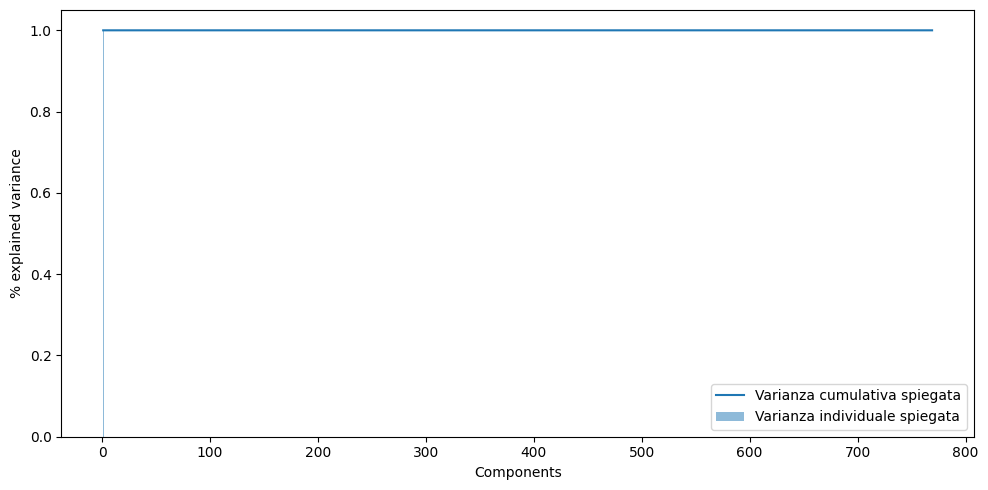

In [104]:
pca = PCA()
pca.fit(df_embeddings)

explained = pca.explained_variance_ratio_
cumulative = np.cumsum(explained)

n_components = np.where(cumulative>=0.95)[0][0]+1

plt.figure(figsize=(10, 5))
plt.bar(range(1, len(explained) + 1), explained, alpha=0.5, align='center', label='Varianza individuale spiegata')
plt.step(range(1, len(cumulative) + 1), cumulative, where='mid', label='Varianza cumulativa spiegata')
plt.ylabel('% explained variance')
plt.xlabel('Components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [105]:
pca = PCA(n_components=n_components)
reduced = pca.fit_transform(df_embeddings)
df_reduced_desc = pd.DataFrame(reduced, columns = [f"pc_desc{i}" for i in range(reduced.shape[1])])

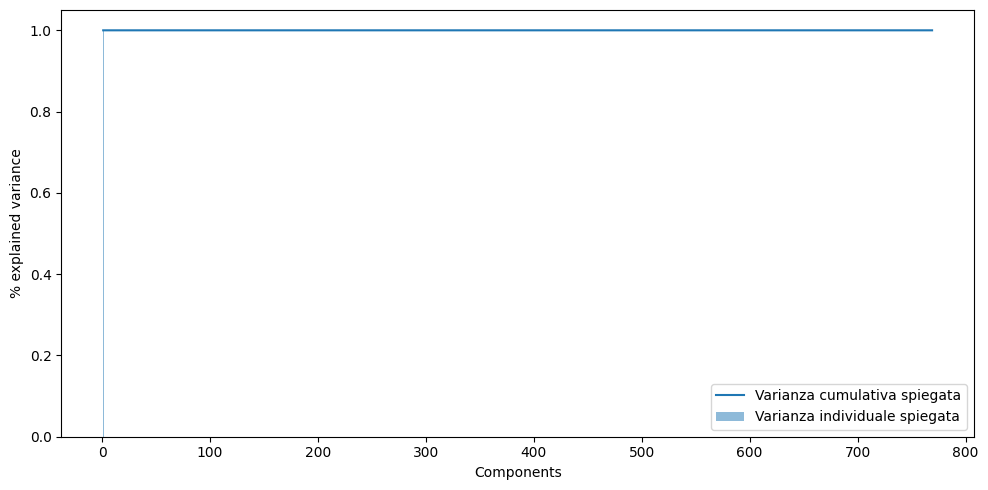

In [106]:
pca = PCA()
pca.fit(df_category_embeddings)

explained = pca.explained_variance_ratio_
cumulative = np.cumsum(explained)

n_components = np.where(cumulative>=0.95)[0][0]+1

plt.figure(figsize=(10, 5))
plt.bar(range(1, len(explained) + 1), explained, alpha=0.5, align='center', label='Varianza individuale spiegata')
plt.step(range(1, len(cumulative) + 1), cumulative, where='mid', label='Varianza cumulativa spiegata')
plt.ylabel('% explained variance')
plt.xlabel('Components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [107]:
pca = PCA(n_components=n_components)
reduced = pca.fit_transform(df_category_embeddings)
df_reduced_cat = pd.DataFrame(reduced, columns = [f"pc_cat{i}" for i in range(reduced.shape[1])])

In [108]:
df_reduced_cat['ItemId'] = items['ItemId']

In [109]:
df_reduced_desc['ItemId'] = items['ItemId']

In [110]:
full_items = items.merge(df_reduced_desc, on='ItemId')
full_items = full_items.merge(df_reduced_cat, on='ItemId')
df_full = full_items.merge(purchases, on='ItemId')

In [111]:
feature_dict = {
    "item_id": df_full["ItemId"].values,
    "collection": df_full["Collection_encoded"].values,
    "gender": df_full["Gender_encoded"].values,
    "date": df_full["CreatedOnUtc"].values,
    "composition": df_full["Composition_encoded"].values,
    "item_embedding" : df_full[[f'pc_desc{i}' for i in range(df_reduced_desc.shape[1]-1)]].values,
    "category_embedding" : df_full[[f'pc_cat{i}' for i in range(df_reduced_cat.shape[1]-1)]].values,
    "user_id": df_full['UserId'].values.reshape(-1,1),
    "interaction" : df_full['Interaction'].values.reshape(-1,1)
}
df_dict = pd.DataFrame({
    "item_id": feature_dict["item_id"],
    "collection": feature_dict["collection"],
    "gender": feature_dict["gender"],
    "composition": feature_dict["composition"],
    "date": feature_dict["date"],
    "user_id": feature_dict["user_id"].reshape(-1),
    "interaction": feature_dict["interaction"].reshape(-1)
})
df_dict['item_embedding'] = list(map(list, feature_dict['item_embedding']))
df_dict['category_embedding'] = list(map(list, feature_dict['category_embedding']))

train_df, val_df, test_df = custom_train_val_test_split(df_dict, test_size=0.2, val_size=0.1)

#Training PCA senza descrizioni

In [112]:
candidates_tf = tf.data.Dataset.from_tensor_slices({
    "item_id": full_items['ItemId'].values.reshape(-1,1),
    "category_embedding" : full_items[[f'pc_cat{i}' for i in range(df_reduced_cat.shape[1]-1)]].values,
    "collection": full_items["Collection_encoded"].values,
    "gender": full_items["Gender_encoded"].values,
    "composition": full_items["Composition_encoded"].values
})
candidates_ds = candidates_tf.batch(32)

In [117]:
exclude_columns = ["item_embeddings"]

train_feature_dict = create_feature_dict_from_df(train_df, exclude_features=exclude_columns)
val_feature_dict = create_feature_dict_from_df(val_df, exclude_features=exclude_columns)
test_feature_dict = create_feature_dict_from_df(test_df, exclude_features=exclude_columns)

In [118]:
train = tf_dataset_from_feature_dict(train_feature_dict, batch_size=32)
val = tf_dataset_from_feature_dict(val_feature_dict, batch_size=32)
test = tf_dataset_from_feature_dict(test_feature_dict, batch_size=32)

In [116]:
class NoDescRecommender(tfrs.Model):

  def __init__(self, user_model, item_model, candidates):
    super().__init__()
    self.user_model = user_model
    self.item_model = item_model
    self.retrieval_task = tfrs.tasks.Retrieval(metrics=tfrs.metrics.FactorizedTopK(
            candidates = candidates.map(self.item_model)))
    self.rank_task = tfrs.tasks.Ranking(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
            metrics=[tf.keras.metrics.BinaryAccuracy()])

  def compute_loss(self, data, training = False):
    features, labels = data
    user_emb = self.user_model({"user_id": features['user_id']
                                })
    item_emb = self.item_model({"category_embedding":features['category_embedding'],
                                "gender":features['gender'],
                                "collection":features['collection'],
                                "composition": features["composition"],
                                })
    retrieval_loss = self.retrieval_task(user_emb, item_emb)
    predictions = tf.reduce_sum(user_emb * item_emb, axis=1)
    ranking_loss = self.rank_task( labels = labels, predictions = predictions)
    return retrieval_loss + ranking_loss

In [119]:
unique_user_ids = df_full['UserId'].unique().astype(str)
unique_item_ids = df_full['ItemId'].unique().astype(str)
embedding_dim = df_reduced_cat.shape[1]-1

In [120]:
category_embedding_input = Input(shape=(df_reduced_cat.shape[1]-1,), name='category_embedding')
gender_input = Input(shape=(1,), name='gender')
collection_input = Input(shape=(1,), name='collection')
composition_input = Input(shape=(1,), name='composition')

item_inputs =[category_embedding_input, gender_input, collection_input, composition_input]
concatenated = Concatenate()(item_inputs)

x = Dense(32, activation='relu')(concatenated)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)


item_model = Model(inputs=item_inputs, outputs=x)

In [121]:
user_id_input = Input(shape=(1,), name="user_id", dtype=tf.int32)
user_embedding = Embedding(input_dim=len(unique_user_ids), output_dim=embedding_dim, name="user_embedding")(user_id_input)

combined_input = Concatenate()([user_embedding])

x = Dense(32, activation="relu")(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Flatten()(x)

user_model = Model(inputs=[user_id_input], outputs=x)

In [122]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=10,
                                              mode='min',
                                              start_from_epoch = 25,
                                              restore_best_weights=True)

In [123]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.999,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [124]:
recommender = NoDescRecommender(user_model, item_model, candidates_ds)
recommender.compile(optimizer = optimizer)
history = recommender.fit(train,
                validation_data = val,
                epochs=100, callbacks=[early_stop])

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['item_id'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


435/435 [==============================] - 69s 153ms/step - factorized_top_k/top_1_categorical_accuracy: 7.1849e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0014 - factorized_top_k/top_10_categorical_accuracy: 0.0022 - factorized_top_k/top_50_categorical_accuracy: 0.0075 - factorized_top_k/top_100_categorical_accuracy: 0.0141 - binary_accuracy: 0.3911 - loss: 134.2039 - regularization_loss: 0.0000e+00 - total_loss: 134.2039 - val_factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_5_categorical_accuracy: 5.2604e-04 - val_factorized_top_k/top_10_categorical_accuracy: 0.0011 - val_factorized_top_k/top_50_categorical_accuracy: 0.0053 - val_factorized_top_k/top_100_categorical_accuracy: 0.0116 - val_binary_accuracy: 0.5455 - val_loss: 36.5669 - val_regularization_loss: 0.0000e+00 - val_total_loss: 36.5669
Epoch 2/100
426/435 [============================>.] - ETA: 1s - factorized_top_k/top_1_categorical_accuracy: 6.6021e-04 - factorized_top_k/top_5_ca

KeyboardInterrupt: 

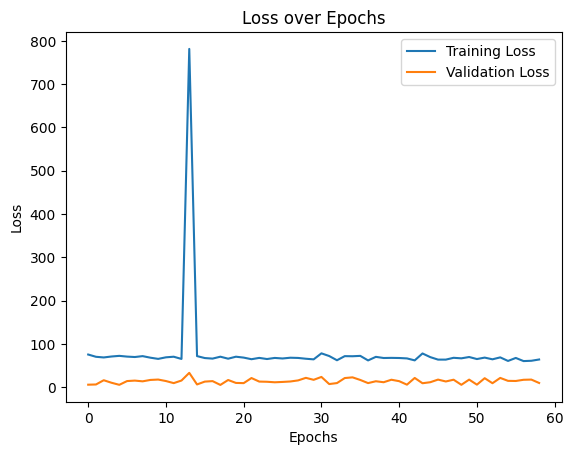

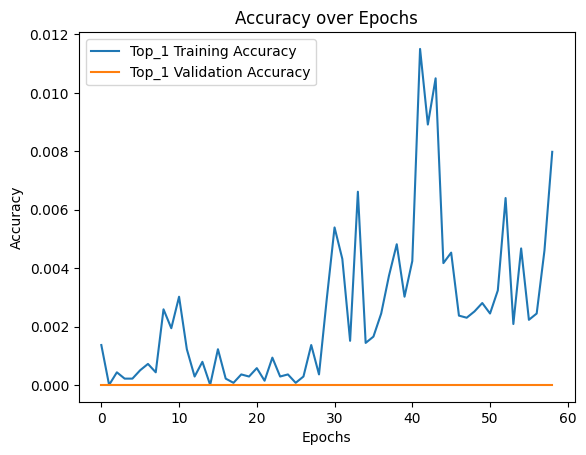

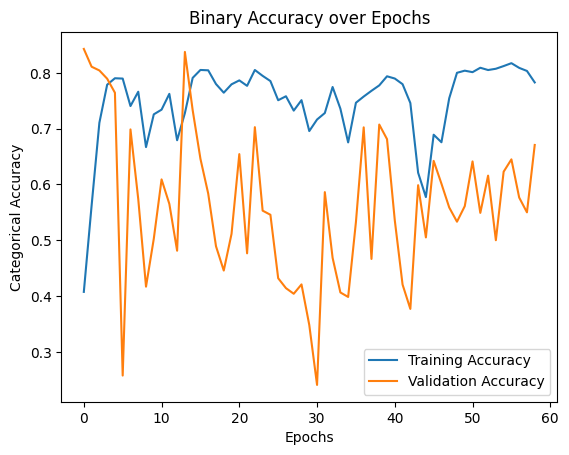

In [53]:
metrics = history.history
plt.plot(metrics['loss'], label='Training Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot top 1 cat accuracy

plt.plot(metrics['factorized_top_k/top_1_categorical_accuracy'], label='Top_1 Training Accuracy')
plt.plot(metrics['val_factorized_top_k/top_1_categorical_accuracy'], label='Top_1 Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot binary accuracy
plt.plot(metrics['binary_accuracy'], label='Training Accuracy')
plt.plot(metrics['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Binary Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Categorical Accuracy')
plt.legend()
plt.show()

In [54]:
test_metrics = recommender.evaluate(test, return_dict=True)
print(test_metrics)

94/94 [==============================] - 12s 128ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 3.3535e-04 - factorized_top_k/top_50_categorical_accuracy: 0.0064 - factorized_top_k/top_100_categorical_accuracy: 0.0154 - binary_accuracy: 0.4430 - loss: 129.8581 - regularization_loss: 0.0000e+00 - total_loss: 129.8581
{'factorized_top_k/top_1_categorical_accuracy': 0.0, 'factorized_top_k/top_5_categorical_accuracy': 0.0, 'factorized_top_k/top_10_categorical_accuracy': 0.0003353453939780593, 'factorized_top_k/top_50_categorical_accuracy': 0.006371562834829092, 'factorized_top_k/top_100_categorical_accuracy': 0.015425888821482658, 'binary_accuracy': 0.4429912865161896, 'loss': 22.295654296875, 'regularization_loss': 0, 'total_loss': 22.295654296875}


In [55]:
recommender.evaluate(test)
recommender.save("pca_nodesc_model.keras")

94/94 [==============================] - 12s 128ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 3.3535e-04 - factorized_top_k/top_10_categorical_accuracy: 6.7069e-04 - factorized_top_k/top_50_categorical_accuracy: 0.0064 - factorized_top_k/top_100_categorical_accuracy: 0.0158 - binary_accuracy: 0.4453 - loss: 129.0736 - regularization_loss: 0.0000e+00 - total_loss: 129.0736


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_api.py:164: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  saving_lib.save_model(model, filepath)


#Training PCA con Descrizioni

In [125]:
candidates_tf = tf.data.Dataset.from_tensor_slices({
    "item_id": full_items['ItemId'].values.reshape(-1,1),
    "item_embedding" : full_items[[f'pc_desc{i}' for i in range(df_reduced_desc.shape[1]-1)]].values,
    "category_embedding" : full_items[[f'pc_cat{i}' for i in range(df_reduced_cat.shape[1]-1)]].values,
    "collection": full_items["Collection_encoded"].values,
    "gender": full_items["Gender_encoded"].values,
    "composition": full_items["Composition_encoded"].values
})
candidates_ds = candidates_tf.batch(32)

In [126]:
exclude_columns = None

train_feature_dict = create_feature_dict_from_df(train_df, exclude_features=exclude_columns)
val_feature_dict = create_feature_dict_from_df(val_df, exclude_features=exclude_columns)
test_feature_dict = create_feature_dict_from_df(test_df, exclude_features=exclude_columns)


In [127]:
train = tf_dataset_from_feature_dict(train_feature_dict, batch_size=32)
val = tf_dataset_from_feature_dict(val_feature_dict, batch_size=32)
test = tf_dataset_from_feature_dict(test_feature_dict, batch_size=32)

In [128]:
class CFRecommender(tfrs.Model):

  def __init__(self, user_model, item_model, candidates):
    super().__init__()
    self.user_model = user_model
    self.item_model = item_model
    self.retrieval_task = tfrs.tasks.Retrieval(metrics=tfrs.metrics.FactorizedTopK(
            candidates = candidates.map(self.item_model)))
    self.rank_task = tfrs.tasks.Ranking(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
            metrics=[tf.keras.metrics.BinaryAccuracy()])

  def compute_loss(self, data, training = False):
    features, labels = data
    user_emb = self.user_model({"user_id": features['user_id']
                                })
    item_emb = self.item_model({"item_embedding":features['item_embedding'],
                                "category_embedding":features['category_embedding'],
                                "gender":features['gender'],
                                "collection":features['collection'],
                                "composition": features["composition"],
                                })
    retrieval_loss = self.retrieval_task(user_emb, item_emb)
    predictions = tf.reduce_sum(user_emb * item_emb, axis=1)
    ranking_loss = self.rank_task(labels = labels, predictions = predictions)
    return retrieval_loss + ranking_loss

In [129]:
unique_user_ids = df_full['UserId'].unique().astype(str)
unique_item_ids = df_full['ItemId'].unique().astype(str)
embedding_dim = df_reduced_desc.shape[1] + df_reduced_cat.shape[1] - 2

In [130]:
item_embedding_input = Input(shape=(df_reduced_desc.shape[1]-1,), name='item_embedding')
category_embedding_input = Input(shape=(df_reduced_cat.shape[1]-1,), name='category_embedding')
gender_input = Input(shape=(1,), name='gender')
collection_input = Input(shape=(1,), name='collection')
composition_input = Input(shape=(1,), name='composition')

item_inputs =[item_embedding_input, category_embedding_input, gender_input, collection_input, composition_input]
concatenated = Concatenate()(item_inputs)

x = Dense(96, activation='relu')(concatenated)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

item_model = Model(inputs=item_inputs, outputs=x)

In [131]:
user_id_input = Input(shape=(1,), name="user_id", dtype=tf.int32)
user_embedding = Embedding(input_dim=len(unique_user_ids), output_dim=embedding_dim, name="user_embedding")(user_id_input)

combined_input = Concatenate()([user_embedding])

x = Dense(96, activation="relu")(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Flatten()(x)

user_model = Model(inputs=[user_id_input], outputs=x)

In [132]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=10,
                                              mode='min',
                                              start_from_epoch = 25,
                                              restore_best_weights=True)

In [133]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.999,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [134]:
recommender = CFRecommender(user_model, item_model, candidates_ds)
recommender.compile(optimizer = optimizer)
history = recommender.fit(train,
                validation_data = val,
                epochs=100, callbacks=[early_stop])

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['item_id'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 32/435 [=>............................] - ETA: 1:00 - factorized_top_k/top_1_categorical_accuracy: 0.0117 - factorized_top_k/top_5_categorical_accuracy: 0.0137 - factorized_top_k/top_10_categorical_accuracy: 0.0186 - factorized_top_k/top_50_categorical_accuracy: 0.0283 - factorized_top_k/top_100_categorical_accuracy: 0.0586 - binary_accuracy: 0.4482 - loss: 263.7319 - regularization_loss: 0.0000e+00 - total_loss: 263.7319

KeyboardInterrupt: 

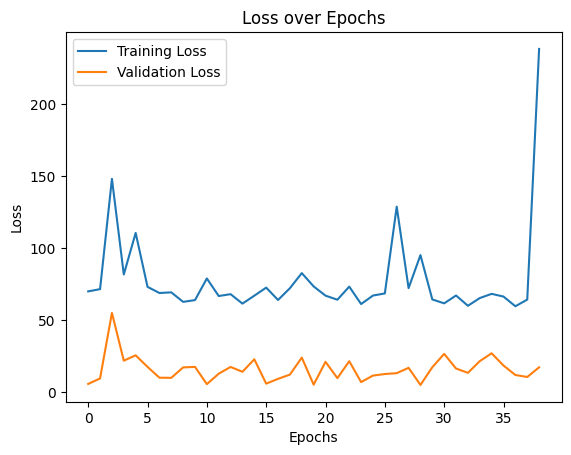

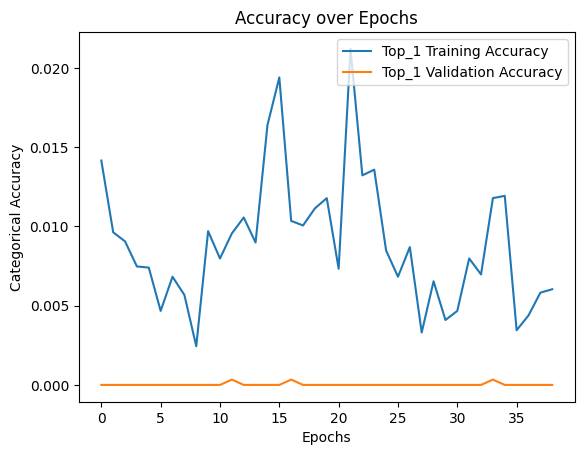

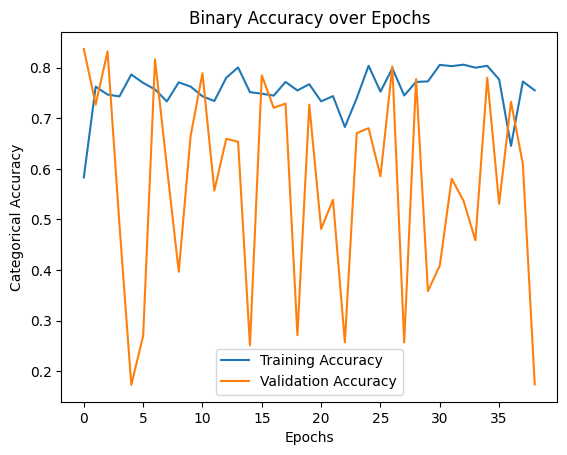

In [69]:
metrics = history.history
# Plot loss
plt.plot(metrics['loss'], label='Training Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot categorical accuracy
plt.plot(metrics['factorized_top_k/top_1_categorical_accuracy'], label='Top_1 Training Accuracy')
plt.plot(metrics['val_factorized_top_k/top_1_categorical_accuracy'], label='Top_1 Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Categorical Accuracy')
plt.legend()
plt.show()

# Plot binary accuracy
plt.plot(metrics['binary_accuracy'], label='Training Accuracy')
plt.plot(metrics['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Binary Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Categorical Accuracy')
plt.legend()
plt.show()

In [70]:
test_metrics = recommender.evaluate(test, return_dict=True)
print(test_metrics)

94/94 [==============================] - 12s 131ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0013 - factorized_top_k/top_10_categorical_accuracy: 0.0034 - factorized_top_k/top_50_categorical_accuracy: 0.0201 - factorized_top_k/top_100_categorical_accuracy: 0.0429 - binary_accuracy: 0.7401 - loss: 148.7975 - regularization_loss: 0.0000e+00 - total_loss: 148.7975
{'factorized_top_k/top_1_categorical_accuracy': 0.0, 'factorized_top_k/top_5_categorical_accuracy': 0.0013413815759122372, 'factorized_top_k/top_10_categorical_accuracy': 0.0033534541726112366, 'factorized_top_k/top_50_categorical_accuracy': 0.02012072503566742, 'factorized_top_k/top_100_categorical_accuracy': 0.04292421042919159, 'binary_accuracy': 0.7401072978973389, 'loss': 26.338682174682617, 'regularization_loss': 0, 'total_loss': 26.338682174682617}


#Tuning dei parametri

In [ ]:
class HyperRecommender(HyperModel):
  def __init__(self, user_input_dim, item_input_dim, embedding_dim, candidates_ds):
    self.user_input_dim = user_input_dim
    self.item_input_dim = item_input_dim
    self.embedding_dim = embedding_dim
    self.candidates_ds = candidates_ds

  def build(self, hp):
    unique_user_ids = df_full['UserId'].unique().astype(str)
    unique_item_ids = df_full['ItemId'].unique().astype(str)
    embedding_dim = df_embeddings.shape[1]-1
    user_model = tf.keras.Sequential([
                                  tf.keras.layers.Embedding(input_dim = len(unique_user_ids), output_dim = embedding_dim),
                                  tf.keras.layers.Dense(hp.Int("dense_size", min_value=2, max_value=32, step=2)),
                                  tf.keras.layers.ReLU(),
                                  tf.keras.layers.Dropout(hp.Float("dropout_rate", min_value = 0.05, max_value = 0.4, step = 0.05)),
                                  tf.keras.layers.Dense(hp.Int("dense_size", min_value=2, max_value=32, step=2)),
                                  tf.keras.layers.Dropout(hp.Float("dropout_rate", min_value = 0.05, max_value = 0.4, step = 0.05)),
                                  tf.keras.layers.Flatten(),
                                  ])
    item_model = tf.keras.Sequential([tf.keras.Input(shape=(embedding_dim,), dtype=tf.float32, name='item_embedding'),
                                  tf.keras.layers.Dense(hp.Int("dense_size", min_value=2, max_value=32, step=2)),
                                  tf.keras.layers.ReLU(),
                                  tf.keras.layers.Dropout(hp.Float("dropout_rate", min_value = 0.05, max_value = 0.4, step = 0.05)),
                                  tf.keras.layers.Dense(hp.Int("dense_size", min_value=2, max_value=32, step=2))
                                ])

    # Define the CFRecommender model
    model = CFRecommender(user_model, item_model, self.candidates_ds)

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=6e-2, sampling='LOG')),
    )

    return model

In [ ]:
hypermodel = HyperRecommender(user_input_dim = len(unique_user_ids),
                              item_input_dim = embedding_dim,
                              embedding_dim = embedding_dim,
                              candidates_ds = candidates_ds)


In [ ]:
tuner = RandomSearch(hypermodel,
                     objective = 'val_loss',
                     max_trials = 50,
                     directory = 'keras_tuner_dir',
                     project_name = 'gs_recommender')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['item_id'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


In [ ]:
tuner.search_space_summary()
tuner.search(train, validation_data=val, epochs=20)
best_hyperparams = tuner.get_best_hyperparameters(num_trials=1)[0]
for hparam in best_hyperparams.values:
  print(f'{hparam}: {best_hyperparams.get(hparam)}')

Trial 49 Complete [00h 19m 40s]
val_loss: 26.628984451293945

Best val_loss So Far: 22.390087127685547
Total elapsed time: 15h 36m 14s

Search: Running Trial #50

Value             |Best Value So Far |Hyperparameter
32                |32                |dense_size
0.4               |0.05              |dropout_rate
0.00036674        |0.0041061         |learning_rate

Epoch 1/20
398/398 [==============================] - 61s 149ms/step - factorized_top_k/top_1_categorical_accuracy: 3.1451e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0010 - factorized_top_k/top_10_categorical_accuracy: 0.0021 - factorized_top_k/top_50_categorical_accuracy: 0.0170 - factorized_top_k/top_100_categorical_accuracy: 0.0359 - binary_accuracy: 0.7246 - loss: 111.0723 - regularization_loss: 0.0000e+00 - total_loss: 111.0723 - val_factorized_top_k/top_1_categorical_accuracy: 0.0038 - val_factorized_top_k/top_5_categorical_accuracy: 0.0069 - val_factorized_top_k/top_10_categorical_accuracy: 0.0091 - val_fac

In [ ]:
best_model = tuner.hypermodel.build(best_hyperparams)
best_history = best_model.fit(train, validation_data=val, epochs=100)

Epoch 1/100
398/398 [==============================] - 62s 152ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0149 - factorized_top_k/top_5_categorical_accuracy: 0.0196 - factorized_top_k/top_10_categorical_accuracy: 0.0243 - factorized_top_k/top_50_categorical_accuracy: 0.0572 - factorized_top_k/top_100_categorical_accuracy: 0.0933 - binary_accuracy: 0.7798 - loss: 109.5902 - regularization_loss: 0.0000e+00 - total_loss: 109.5902 - val_factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_5_categorical_accuracy: 3.1456e-04 - val_factorized_top_k/top_10_categorical_accuracy: 3.1456e-04 - val_factorized_top_k/top_50_categorical_accuracy: 0.0116 - val_factorized_top_k/top_100_categorical_accuracy: 0.0377 - val_binary_accuracy: 0.8119 - val_loss: 33.5852 - val_regularization_loss: 0.0000e+00 - val_total_loss: 33.5852
Epoch 2/100
398/398 [==============================] - 59s 149ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0208 - factorized

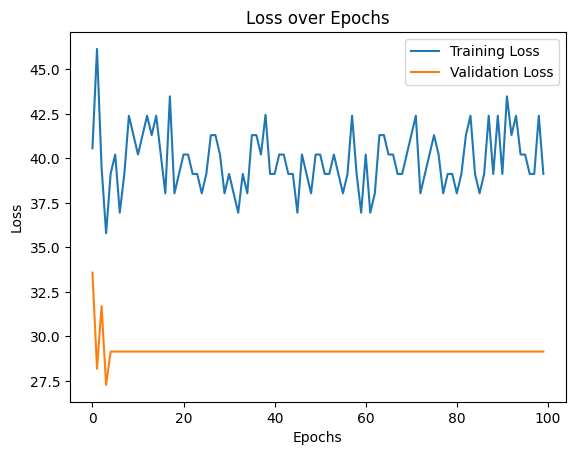

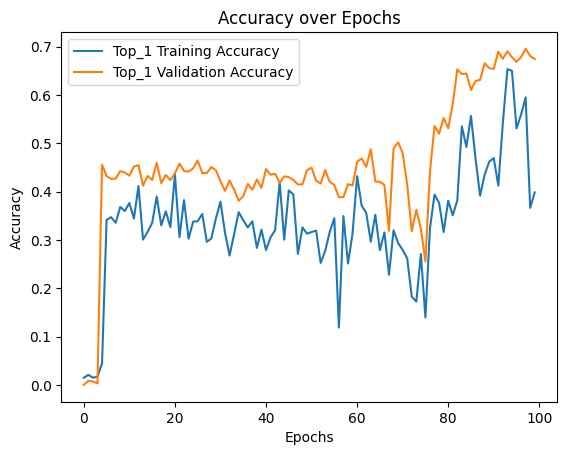

In [ ]:
metrics = best_history.history
plt.plot(metrics['loss'], label='Training Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotta l'accuracy di training
plt.plot(metrics['factorized_top_k/top_1_categorical_accuracy'], label='Top_1 Training Accuracy')
plt.plot(metrics['val_factorized_top_k/top_1_categorical_accuracy'], label='Top_1 Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
recommender.evaluate(test)

125/125 [==============================] - 14s 114ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0058 - factorized_top_k/top_5_categorical_accuracy: 0.1361 - factorized_top_k/top_10_categorical_accuracy: 0.1361 - factorized_top_k/top_50_categorical_accuracy: 0.1376 - factorized_top_k/top_100_categorical_accuracy: 0.1401 - binary_accuracy: 0.8179 - loss: 116.1739 - regularization_loss: 0.0000e+00 - total_loss: 116.1739


[0.005786163732409477,
 0.136100634932518,
 0.136100634932518,
 0.13761006295681,
 0.14012578129768372,
 0.8178616166114807,
 20.72789764404297,
 0,
 20.72789764404297]


#Raccomandazioni per utente e per articolo

In [ ]:
def user_recommendations(user_id, brute_force, k=5):
  user_id_tensor = tf.convert_to_tensor([[user_id]])
  _, item_ids = brute_force(user_id_tensor, k)
  return item_ids.numpy().flatten()

In [ ]:
def similar_items(item_id, item_model, candidates_embeddings,candidates_ids,embedding_dim, k=5):
  input = df_embeddings.iloc[item_id].values[:embedding_dim].reshape(1, -1)
  item_embedding = item_model.predict(input)
  scores = tf.matmul(item_embedding, candidates_embeddings.T)
  top_k_indices = tf.math.top_k(scores, k=k+1).indices.numpy().flatten()
  top_k_indices = top_k_indices[top_k_indices != item_id]
  return [candidates_ids[i] for i in top_k_indices[:k]]

In [ ]:
candidates_embeddings = item_model.predict(df_embeddings.values[:, :-1])
candidate_ids = full_items['ItemId'].values

brute_force = tfrs.layers.factorized_top_k.BruteForce(user_model)
brute_force.index(candidates_embeddings, identifiers=candidate_ids)

110/110 [==============================] - 0s 1ms/step


In [ ]:
uid = customers[customers['CustomerId']== 91311]['UserId']
print("User bought")
print(df_full[df_full['UserId']==uid.iloc[0]])
recommendation_ids = user_recommendations(uid.iloc[0], brute_force)
items[items['ItemId'].isin(recommendation_ids)]

User bought
                      Sku                     ItemName  \
5246   A20215810122793607    VINTAGE MERINOS CARDIGAN    
5259   A20215810122793012    VINTAGE MERINOS CARDIGAN    
8815   P20225516718190266           COTTON CREW NECK     
9317   P20225712820607598            STRIPED KNIT POLO   
9616   P20225713621810040  ORGANIC COTTON KNIT T-SHIRT   
11596  A20225516714290140       MERINOS WOOL CREW NECK   
13490  P20236013374002001    MERCERIZED COTTON T-SHIRT   
16117  P20235516718190001           COTTON CREW NECK     

                                                Category  UnitPrice  ItemId  \
5246                            ['Maglieria', 'Giacche']     343.64     969   
5259                            ['Maglieria', 'Giacche']     343.64     970   
8815                                       ['Maglieria']     125.00    1541   
9317   ['Polo, Camicie e T-shirt', 'Polo, Camicie e T...     399.36    1605   
9616              ['Polo, Camicie e T-shirt', 'Vintage']     150.00   

,Sku,ItemName,Category,UnitPrice,ItemId,Collection,Availability,Color,Gender,Description,Composition,TextInfo,Category_combined
1702,P20226028471213598,SHORT-SLEEVED SWEATSHIRT,['Maglieria'],155.00,1702,Spring-Summer,0,598,Women,cotton sweatshirtstyle shortsleeved sweater fe...,cotton,short-sleeved sweatshirt cotton sweatshirtstyl...,[ ' M a g l i e r i a ' ]
2853,P20235719720654110,RAGLAN KNIT BOMBER,"['Maglieria, Giacche']",327.95,2853,Spring-Summer,1,110,Men,fresh cotton raglan sleeve bomberstyle jacket ...,cotton,raglan knit bomber fresh cotton raglan sleeve ...,"[ ' M a g l i e r i a , G i a c c h e ' ]"
2880,P20235719720654598,RAGLAN KNIT BOMBER,"['Maglieria, Giacche']",327.95,2880,Spring-Summer,1,598,Men,fresh cotton raglan sleeve bomberstyle jacket ...,cotton,raglan knit bomber fresh cotton raglan sleeve ...,"[ ' M a g l i e r i a , G i a c c h e ' ]"
2892,P20231313518626120,CELLULAR STITCH RAGLAN FULL ZIP,"['Maglieria, Giacche']",254.98,2892,Spring-Summer,1,120,Men,cellular stitch 3ply linen and cotton raglan s...,linen,cellular stitch raglan full zip cellular stitc...,"[ ' M a g l i e r i a , G i a c c h e ' ]"
2904,P20235716669312598,ORGANIC COTTON DOUBLE-FACE GILET,"['Maglieria, Giacche']",370.00,2904,Spring-Summer,1,598,Men,reversible sleeveless jacket with hood doubles...,nylon,organic cotton double-face gilet reversible sl...,"[ ' M a g l i e r i a , G i a c c h e ' ]"


In [ ]:
item_id = 0
similar_to = similar_items(item_id, item_model, candidates_embeddings, candidate_ids,embedding_dim, k=5)
items[items['ItemId'].isin(similar_to)]